# XGBoostを使用してみる

## 参考資料
* https://qiita.com/predora005/items/19aebcf3aa05946c7cf4
* https://qiita.com/automation2025/items/6f0d6ff4abe106a2dd89
* https://xgboost.readthedocs.io/en/latest/install.html

### インストール

私の環境では`-cpu`をつけないと`import`の時にエラーが出てしまい、インポートできなかった。
MacBook Air(2022 M2), OS : Sonama 14.2.1

In [3]:
! pip install xgboost-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.6 MB/s eta 0:00:00ta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xgboost-cpu: filename=xgboost_cpu-3.0.2-py3-none-macosx_14_0_arm64.whl size=1890145 sha256=f68b28e4892468e33f8b8d74f31a051a9ddd41753bec1ff5046df8717bcd2f11
  Stored in directory: /Users/kazuki/Library/Caches/pip/wheels/9b/6d/4f/a214b84c8b318dc4c2818716c27d5a53e04b5335917789eb0c
Successfully built xgboost-cpu


### インポート

In [23]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

### データの準備

In [6]:
train = pd.read_csv("../data/input/train.csv")
test = pd.read_csv("../data/input/test.csv")
submission = pd.read_csv("../data/input/sample_submission.csv")

`LabelEncoder()`を用いて文字列をアルファベット順に番号づけする。

In [7]:
le = LabelEncoder()
train["Personality_encoded"] = le.fit_transform(train["Personality"])

カテゴリカルな特徴量を数値に変換する。

In [15]:
categorical_cols = train.select_dtypes(exclude=['number']).columns

for col in categorical_cols:
    train[col] = le.fit_transform(train[col])

`drop`を使用して`id`から`Personality`を除いたデータフレームを作成

In [16]:
X = train.drop(columns=["id", "Personality", "Personality_encoded"])
y = train["Personality_encoded"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

### XGBoost用の型`DMatrix`に変換する

In [18]:
print(X_train.dtypes)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Time_spent_Alone             float64
Stage_fear                     int64
Social_event_attendance      float64
Going_outside                float64
Drained_after_socializing      int64
Friends_circle_size          float64
Post_frequency               float64
dtype: object


### パラメータの設定

公式Documentが参考になる。今回はパラメータの設定方法の勉強としてソフトマックス関数を使用し、分類するクラスは2にする。 <br>
公式Document : https://xgboost.readthedocs.io/en/latest/parameter.html

In [19]:
params = {
    'objective': 'multi:softmax',  # ソフトマックス関数を使用
    'num_class': 2,  # 分類するクラス数
}

### 学習と予測

In [21]:
bst = xgb.train(params, dtrain)
y_pred = bst.predict(dtest)

### 結果の確認

In [24]:
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {score:.4f}')

Accuracy: 0.9690


### どの特徴量が予測結果に寄与したか確認

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

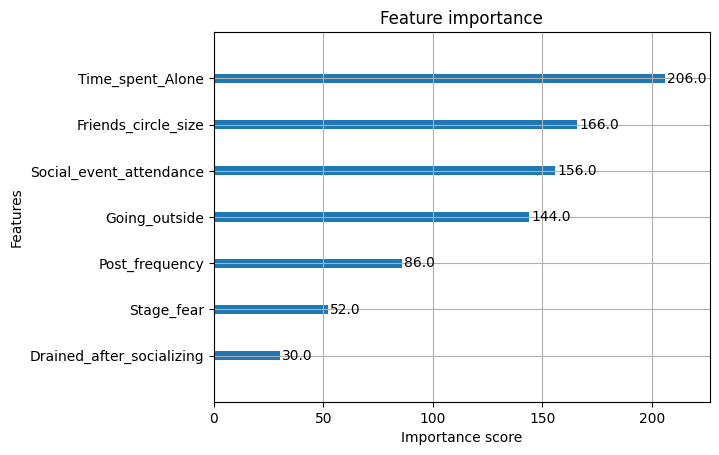

In [25]:
xgb.plot_importance(bst)

### 個々の決定木の可視化

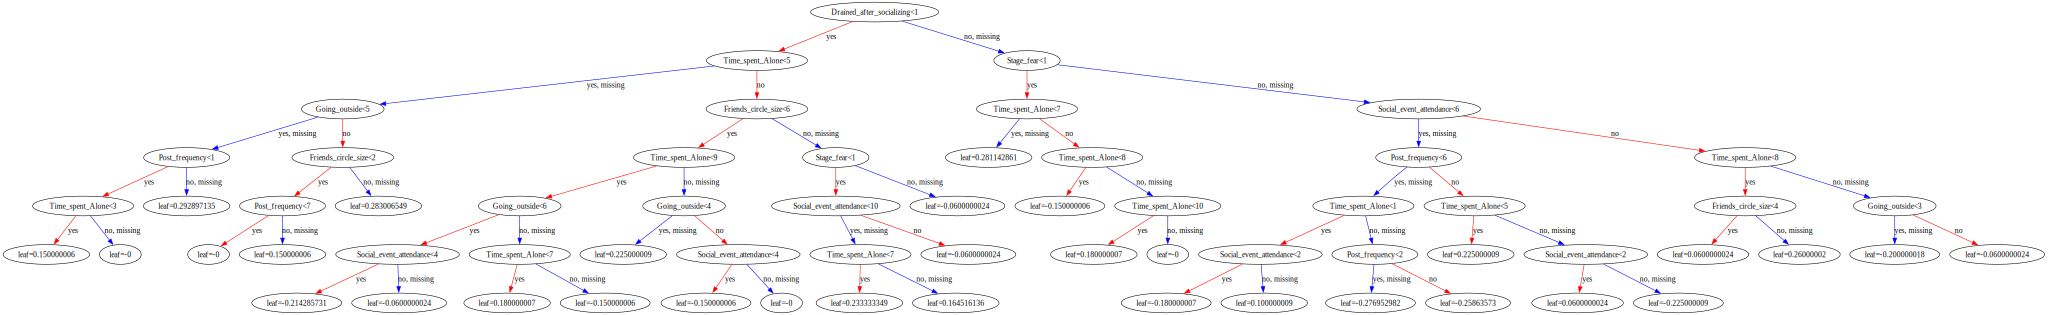

In [34]:
from IPython.display import SVG, display

gv = xgb.to_graphviz(bst, tree_idx=0)
gv.format = 'svg'
display(SVG(gv.pipe(format='svg')))

### 学習曲線の可視化

In [37]:
results = bst.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()

AttributeError: 'Booster' object has no attribute 'evals_result'